# Case/Control Detection Layer

In [1]:
# Enhanced imports with better error handling
%pip install optuna -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparation before training

In [2]:
# Call Dataset
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('consolidated_dataset.csv')
initial_df.info()
initial_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Columns: 128 entries, PtID to ts_number_variability
dtypes: float64(88), int64(1), object(39)
memory usage: 187.1+ KB


,PtID,BCaseControlStatus,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,...,ts_avg_hypo_total,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability
0,1,Case,Disagree,Disagree,Disagree,Agree,Disagree,170.0,80.0,NaN,...,25.0,120.0,0.402196,1.930539,13.2,18.0,1.749591,2.702625,0.0,0.0
1,2,Control,Neutral,Disagree,Disagree,Neutral,Agree,175.0,80.0,6.8,...,9.0,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0
2,3,Control,Disagree,Disagree,Disagree,Agree,Disagree,200.0,70.0,NaN,...,1.0,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0
3,5,Control,Disagree,Disagree,Agree,Agree,Disagree,100.0,70.0,NaN,...,0.0,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0
4,6,Case,Disagree,Neutral,Disagree,Agree,Disagree,250.0,NaN,7.0,...,10.0,120.0,0.190186,2.282232,5.0,11.6,0.738032,2.030869,0.0,0.0


In [3]:
# All categorical features except for label
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
if 'BCaseControlStatus' in categorical_features:
    categorical_features.remove('BCaseControlStatus')

# Label Encode all categorical, but keep missing values
le_initial_df = initial_df.copy()
# Remove PtID since it's not a feature but an identifier
if 'PtID' in le_initial_df.columns:
    le_initial_df = le_initial_df.drop('PtID', axis=1)

# Save the target labels and remove from features
dropped_labels = le_initial_df['BCaseControlStatus']
le_initial_df = le_initial_df.drop('BCaseControlStatus', axis=1)

# Label encode categorical features
for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')

        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])

        # Replace missing values with NaN
        try:
            missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
            le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)
        except:
            print(f"No 'missing' values in column {col}")

# Add back the target labels
le_initial_df = pd.concat([le_initial_df, dropped_labels], axis=1)

In [4]:
le_initial_df

,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,1.0,1.0,1.0,0.0,1.0,170.0,80.0,NaN,0.0,15.0,...,120.0,0.402196,1.930539,13.2,18.0,1.749591,2.702625,0.0,0.0,Case
1,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,Control
2,1.0,1.0,1.0,0.0,1.0,200.0,70.0,NaN,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,Control
3,1.0,1.0,0.0,0.0,1.0,100.0,70.0,NaN,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,Control
4,1.0,2.0,1.0,0.0,1.0,250.0,NaN,7.0,0.0,61.0,...,120.0,0.190186,2.282232,5.0,11.6,0.738032,2.030869,0.0,0.0,Case
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,0.0,0.0,0.0,0.0,200.0,70.0,6.5,0.0,36.0,...,120.0,0.066402,2.656093,1.0,10.0,0.251770,2.448209,0.0,0.0,Case
183,0.0,1.0,0.0,0.0,1.0,150.0,90.0,7.0,0.0,NaN,...,120.0,0.223930,2.239299,6.0,11.6,0.907510,2.005705,0.0,0.0,Case
184,1.0,1.0,1.0,0.0,1.0,250.0,50.0,6.0,0.0,NaN,...,120.0,0.321986,2.575887,10.8,10.8,1.675989,2.513749,0.0,0.0,Case
185,1.0,1.0,1.0,0.0,1.0,200.0,95.0,7.0,0.0,30.0,...,120.0,0.073306,2.199167,2.0,10.4,0.326373,2.226431,0.0,0.0,Case


In [5]:
# Separate data by Case/Control status
le_df_control = le_initial_df[le_initial_df['BCaseControlStatus'] == 'Control']
le_df_case = le_initial_df[le_initial_df['BCaseControlStatus'] == 'Case']

# Check case/control category counts
dataframes = [le_df_control, le_df_case]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['BCaseControlStatus'].value_counts()
print("Case/Control counts:")
print(label_counts)

Case/Control counts:
Control    94
Case       93
Name: BCaseControlStatus, dtype: int64


In [6]:
# Remove samples with too many missing values (more than 80%)
threshold = int(0.8 * le_df_control.shape[1])
le_df_control = le_df_control.dropna(thresh=threshold)
threshold = int(0.8 * le_df_case.shape[1])
le_df_case = le_df_case.dropna(thresh=threshold)

# Check case/control category counts after removing outliers
dataframes = [le_df_control, le_df_case]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['BCaseControlStatus'].value_counts()
print("Case/Control counts after removing outliers:")
print(label_counts)

Case/Control counts after removing outliers:
Control    94
Case       93
Name: BCaseControlStatus, dtype: int64


In [7]:
# Imputation
different_le_dfs = [le_df_control, le_df_case]
imputed_le_dfs = []
from sklearn.impute import IterativeImputer

for le_df in different_le_dfs:
    y = le_df['BCaseControlStatus']
    X = le_df.drop('BCaseControlStatus', axis=1)
    
    imputer = SimpleImputer(strategy='median')
    imputed_data = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

    imputed_df['BCaseControlStatus'] = y.reset_index(drop=True)
    imputed_le_dfs.append(imputed_df)

concatenated_le_dfs = pd.concat(imputed_le_dfs, ignore_index=True)
print("Dataset shape after imputation:", concatenated_le_dfs.shape)
concatenated_le_dfs.head()

Dataset shape after imputation: (187, 127)


,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,Control
1,1.0,1.0,1.0,0.0,1.0,200.0,70.0,6.8,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,Control
2,1.0,1.0,0.0,0.0,1.0,100.0,70.0,6.8,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,Control
3,0.0,1.0,2.0,2.0,0.0,170.0,75.0,6.5,1.0,37.5,...,120.0,0.369918,2.096205,10.0,10.0,1.391627,1.714136,0.0,0.0,Control
4,0.0,1.0,1.0,0.0,2.0,200.0,45.0,6.0,0.0,15.0,...,120.0,0.238981,2.031335,7.0,15.6,1.075851,2.209218,0.0,0.0,Control


In [8]:
# Full label encode depression category
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()

# Full label encode Case/Control status
fully_LE_concatenated_le_dfs['BCaseControlStatus'] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs['BCaseControlStatus'])

# Print the mapping of encoded values
print("Case/Control Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

# The dataset after category connect, imputation, and label encoding
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
splitted_dataset

Case/Control Encoding Mapping:
Case -> 0
Control -> 1


,DealHypoEp_attitude,UndertreatHypo_attitude,HighBGDamage_attitude,FreqHypoDamage_attitude,DangersHighBG_attitude,HighBGLevTakeAction_attitude,LowBGLevTakeAction_attitude,PtCurrA1cGoal_attitude,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,ts_avg_number_total,ts_avg_hypo_mean,ts_avg_number_mean,ts_avg_hypo_max,ts_avg_number_max,ts_avg_hypo_std,ts_avg_number_std,ts_hypo_variability,ts_number_variability,BCaseControlStatus
0,2.0,1.0,1.0,2.0,0.0,175.0,80.0,6.8,0.0,22.0,...,120.0,0.155735,2.076471,6.0,8.6,0.835011,1.730804,0.0,0.0,1
1,1.0,1.0,1.0,0.0,1.0,200.0,70.0,6.8,0.0,40.0,...,120.0,0.018066,2.167922,1.0,7.8,0.134396,1.785497,0.0,0.0,1
2,1.0,1.0,0.0,0.0,1.0,100.0,70.0,6.8,0.0,30.0,...,120.0,0.000000,2.055898,0.0,10.6,0.000000,1.907637,0.0,0.0,1
3,0.0,1.0,2.0,2.0,0.0,170.0,75.0,6.5,1.0,37.5,...,120.0,0.369918,2.096205,10.0,10.0,1.391627,1.714136,0.0,0.0,1
4,0.0,1.0,1.0,0.0,2.0,200.0,45.0,6.0,0.0,15.0,...,120.0,0.238981,2.031335,7.0,15.6,1.075851,2.209218,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,0.0,0.0,0.0,0.0,200.0,70.0,6.5,0.0,36.0,...,120.0,0.066402,2.656093,1.0,10.0,0.251770,2.448209,0.0,0.0,0
183,0.0,1.0,0.0,0.0,1.0,150.0,90.0,7.0,0.0,36.0,...,120.0,0.223930,2.239299,6.0,11.6,0.907510,2.005705,0.0,0.0,0
184,1.0,1.0,1.0,0.0,1.0,250.0,50.0,6.0,0.0,36.0,...,120.0,0.321986,2.575887,10.8,10.8,1.675989,2.513749,0.0,0.0,0
185,1.0,1.0,1.0,0.0,1.0,200.0,95.0,7.0,0.0,30.0,...,120.0,0.073306,2.199167,2.0,10.4,0.326373,2.226431,0.0,0.0,0


### Setup for training

In [9]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))
    
    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4, 
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=22, frameon=True, framealpha=0.9)
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg')
    plt.show()

    display(FileLink(filename))

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.

    This function is deprecated and will be removed in Orange 3.34.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    This function is deprecated and will be removed in Orange 3.34.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize = 14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

In [10]:
warnings.filterwarnings('ignore')

### Training (classic/static)
In order to run classical/static, make sure to uncomment the one you need. "Post Training" is after one of these classical/static is done. The model predicts Case vs Control status.

#### Classical Classifiers

In [11]:
# Optimized Classifiers
classifiers = {
    'DT': DecisionTreeClassifier(
        random_state=0, 
        criterion='gini', 
        max_depth=6, 
        min_samples_leaf=10, 
        min_samples_split=9
    ),
    'LR': LogisticRegression(
        random_state=0, 
        C=0.09659168435718246, 
        max_iter=100, 
        solver='lbfgs'
    ),
    'NB': GaussianNB(
        var_smoothing=0.0058873326349240295
    ),
    'KN': KNeighborsClassifier(
        metric='manhattan', 
        n_neighbors=8, 
        weights='uniform'
    ),
    'MLP': MLPClassifier(
        random_state=0, 
        max_iter=1000, 
        alpha=0.0003079393718075164, 
        hidden_layer_sizes=195, 
        learning_rate_init=0.0001675266159417717
    ),
    'SVC': SVC(probability=True, kernel='rbf', C=0.95, gamma='scale')
}

# Main
# Initialize
metric_sums_classic = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_classic = defaultdict(list)
roc_curves_classic = defaultdict(list)
roc_aucs_classic  = defaultdict(list)
accuracy_scores_classic  = defaultdict(list)
precision_scores_classic  = defaultdict(list)
recall_scores_classic  = defaultdict(list)
f1_scores_classic  = defaultdict(list)

# Loop over 10 different random states
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    # Splitting the data
    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    # Identify outliers in the training dataset
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    # Select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)
    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    # Normalization
    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Correlation Feat Analysis
    corr_df = X_res.copy()
    corr_df['target'] = y_res
    
    corr_mat = corr_df.corr()
    target_correlation = corr_mat['target'].drop('target')
    top_features = target_correlation.abs().sort_values(ascending=False).head(200).index.tolist()
    
    # Only take top features
    X_res_fi = X_res[top_features]
    X_test_fi = X_test[top_features]

    # Evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Ensure the random state for classifiers is consistent
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums_classic[clf_name]['accuracy'] += accuracy
        metric_sums_classic[clf_name]['precision'] += precision
        metric_sums_classic[clf_name]['recall'] += recall
        metric_sums_classic[clf_name]['f1'] += f1
        conf_matrices_classic[clf_name].append(conf_matrix)
        roc_curves_classic[clf_name].append((fpr, tpr))
        roc_aucs_classic[clf_name].append(roc_auc)
        accuracy_scores_classic[clf_name].append(accuracy)
        precision_scores_classic[clf_name].append(precision)
        recall_scores_classic[clf_name].append(recall)
        f1_scores_classic[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
DT - Accuracy: 0.8214, Precision: 0.8281, Recall: 0.8214, F1-Score: 0.8205
LR - Accuracy: 0.7857, Precision: 0.7995, Recall: 0.7857, F1-Score: 0.7832
NB - Accuracy: 0.6607, Precision: 0.6900, Recall: 0.6607, F1-Score: 0.6471
KN - Accuracy: 0.7321, Precision: 0.7398, Recall: 0.7321, F1-Score: 0.7300
MLP - Accuracy: 0.7321, Precision: 0.7398, Recall: 0.7321, F1-Score: 0.7300
SVC - Accuracy: 0.7857, Precision: 0.7995, Recall: 0.7857, F1-Score: 0.7832
Processing for Random State: 1
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of t


Average Metrics over 10 Random States:
DT - Accuracy: 0.7571 ± 0.0446, Precision: 0.7605 ± 0.0455, Recall: 0.7571 ± 0.0446, F1-Score: 0.7564 ± 0.0447, AUC: 0.8219
LR - Accuracy: 0.7107 ± 0.0390, Precision: 0.7146 ± 0.0417, Recall: 0.7107 ± 0.0390, F1-Score: 0.7096 ± 0.0387, AUC: 0.8247
NB - Accuracy: 0.7071 ± 0.0593, Precision: 0.7198 ± 0.0552, Recall: 0.7071 ± 0.0593, F1-Score: 0.7011 ± 0.0651, AUC: 0.7930
KN - Accuracy: 0.7000 ± 0.0540, Precision: 0.7045 ± 0.0549, Recall: 0.7000 ± 0.0540, F1-Score: 0.6984 ± 0.0541, AUC: 0.7920
MLP - Accuracy: 0.7089 ± 0.0375, Precision: 0.7146 ± 0.0382, Recall: 0.7089 ± 0.0375, F1-Score: 0.7070 ± 0.0378, AUC: 0.7847
SVC - Accuracy: 0.7196 ± 0.0299, Precision: 0.7264 ± 0.0326, Recall: 0.7196 ± 0.0299, F1-Score: 0.7177 ± 0.0298, AUC: 0.8412


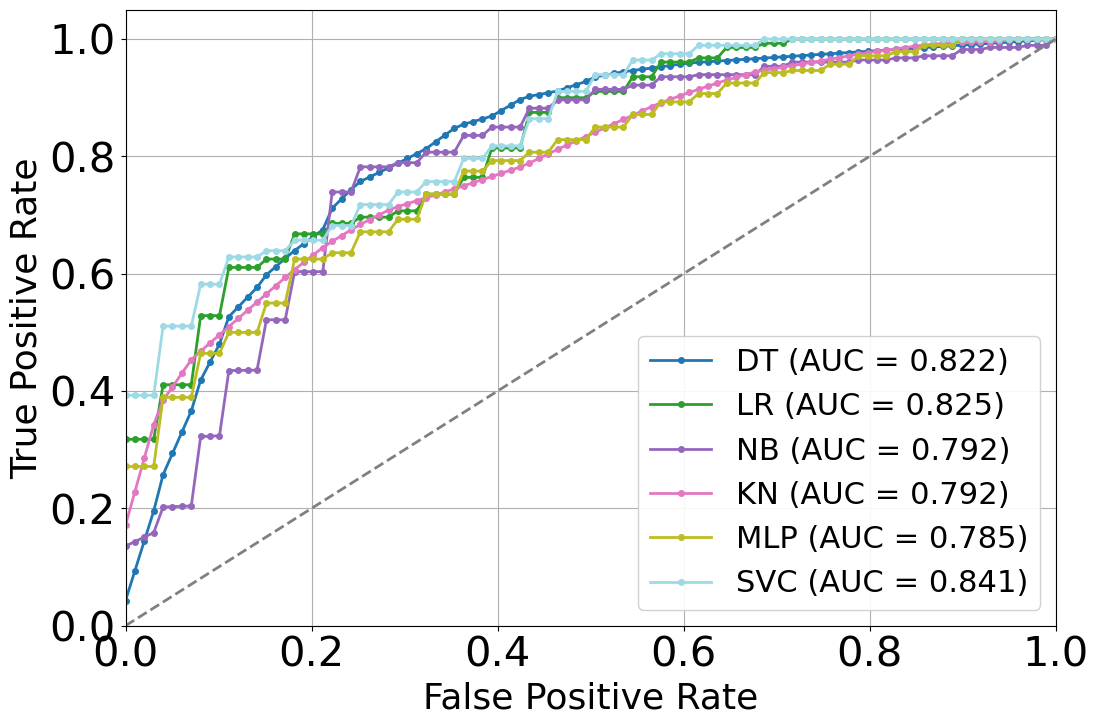

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

Friedman Test Statistic: 10.553846153846136, p-value: 0.060979707514195694
Critical Difference: 2.384234260914288


<Figure size 1400x800 with 0 Axes>

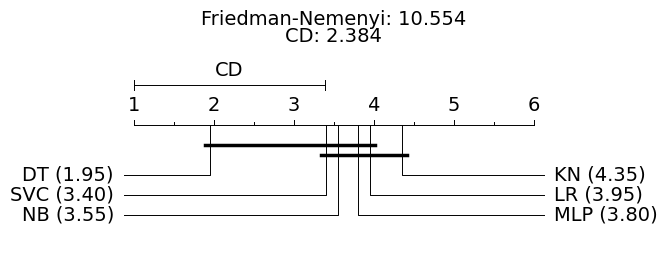

In [12]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_classic.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_classic[clf_name])
    std_precision = np.std(precision_scores_classic[clf_name])
    std_recall = np.std(recall_scores_classic[clf_name])
    std_f1 = np.std(f1_scores_classic[clf_name])
    avg_auc = np.mean(roc_aucs_classic[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves_classic, classifiers.keys())

# Friedman Test and CD Diagram
df = pd.DataFrame(accuracy_scores_classic)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers_ranked = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers_ranked, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

#### Static Classifiers

In [ ]:
# Initialize
metric_sums_static = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_static = defaultdict(list)
roc_curves_static = defaultdict(list)
roc_aucs_static = defaultdict(list)
accuracy_scores_static = defaultdict(list)
precision_scores_static = defaultdict(list)
recall_scores_static = defaultdict(list)
f1_scores_static = defaultdict(list)

# Optimized Classifiers
classifiers = {
    'RF': RandomForestClassifier(random_state=0),
    'XGB': XGBClassifier(random_state=0, eval_metric='logloss'),
    'GB': GradientBoostingClassifier(random_state=0),
    'AB': AdaBoostClassifier(random_state=0),
    'CB': CatBoostClassifier(random_state=0, verbose=0),
}

# Define the number of features for each classifier
num_features = {
     'RF': 150,
     'XGB': 150,
     'GB': 150,
     'AB': 150,
     'CB': 150,
     # 'LGBM': 150,
     # 'Vot': 150
}

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}") 
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices]

    for clf_name, clf in classifiers.items():
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]

        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
        )
        metric_sums_static[clf_name]['accuracy'] += accuracy
        metric_sums_static[clf_name]['precision'] += precision
        metric_sums_static[clf_name]['recall'] += recall
        metric_sums_static[clf_name]['f1'] += f1
        conf_matrices_static[clf_name].append(conf_matrix)
        roc_curves_static[clf_name].append((fpr, tpr))
        roc_aucs_static[clf_name].append(roc_auc)
        accuracy_scores_static[clf_name].append(accuracy)
        precision_scores_static[clf_name].append(precision)
        recall_scores_static[clf_name].append(recall)
        f1_scores_static[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
RF - Accuracy: 0.7500, Precision: 0.7620, Recall: 0.7500, F1-Score: 0.7471
XGB - Accuracy: 0.8393, Precision: 0.8432, Recall: 0.8393, F1-Score: 0.8388
GB - Accuracy: 0.8393, Precision: 0.8505, Recall: 0.8393, F1-Score: 0.8380
AB - Accuracy: 0.7679, Precision: 0.7682, Recall: 0.7679, F1-Score: 0.7678
CB - Accuracy: 0.8929, Precision: 0.8949, Recall: 0.8929, F1-Score: 0.8927
Processing for Random State: 1
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype

### Post Training (classic/static)
Only run after one of the training methods above are done

In [25]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_static[clf_name])
    std_precision = np.std(precision_scores_static[clf_name])
    std_recall = np.std(recall_scores_static[clf_name])
    std_f1 = np.std(f1_scores_static[clf_name])
    avg_auc = np.mean(roc_aucs_static[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RF - Accuracy: 0.7625 ± 0.0473, Precision: 0.7677 ± 0.0466, Recall: 0.7625 ± 0.0473, F1-Score: 0.7612 ± 0.0478, AUC: 0.8708
XGB - Accuracy: 0.7768 ± 0.0507, Precision: 0.7791 ± 0.0508, Recall: 0.7768 ± 0.0507, F1-Score: 0.7762 ± 0.0511, AUC: 0.8814
GB - Accuracy: 0.7768 ± 0.0610, Precision: 0.7820 ± 0.0603, Recall: 0.7768 ± 0.0610, F1-Score: 0.7755 ± 0.0619, AUC: 0.8619
AB - Accuracy: 0.7625 ± 0.0479, Precision: 0.7664 ± 0.0478, Recall: 0.7625 ± 0.0479, F1-Score: 0.7616 ± 0.0481, AUC: 0.8171
CB - Accuracy: 0.8089 ± 0.0524, Precision: 0.8159 ± 0.0501, Recall: 0.8089 ± 0.0524, F1-Score: 0.8076 ± 0.0532, AUC: 0.8967


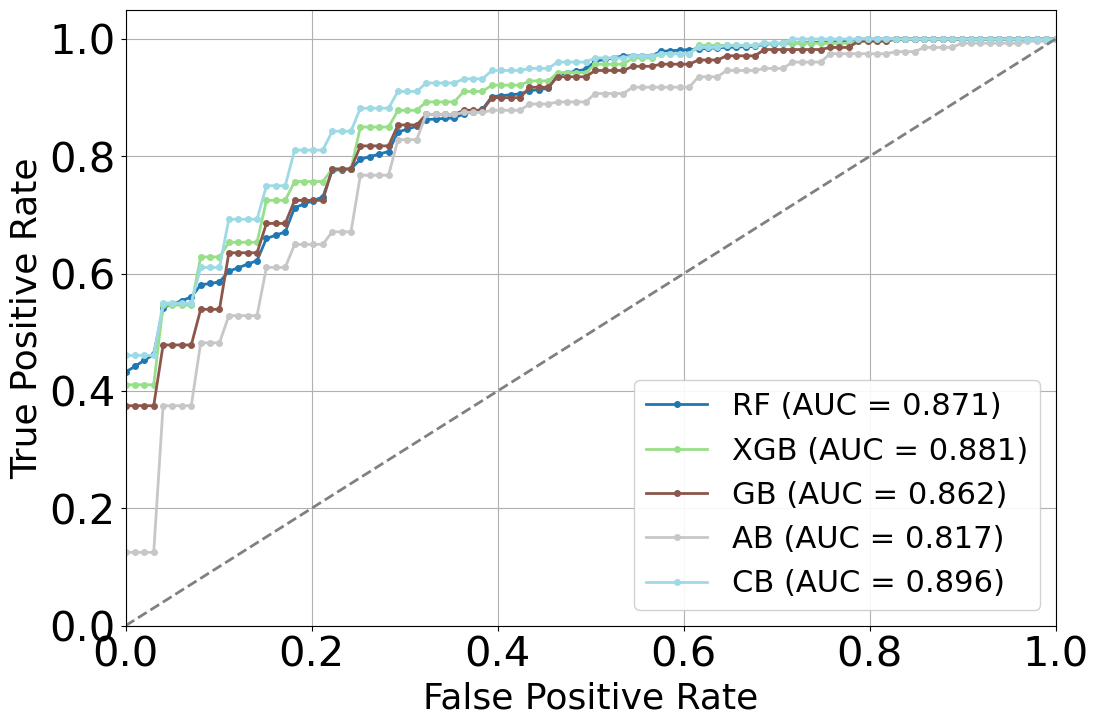

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [26]:
# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves_static, classifiers.keys())

Friedman Test Statistic: 8.826086956521744, p-value: 0.0655965629614354
Critical Difference: 1.9288274929443536


<Figure size 1400x800 with 0 Axes>

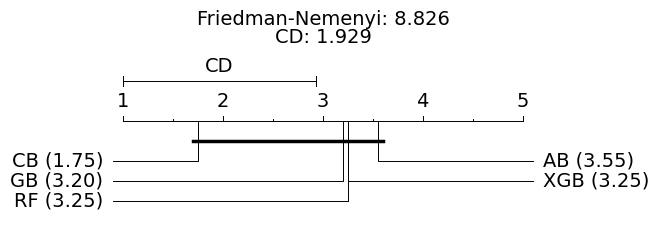

In [27]:
# FN Curve
df = pd.DataFrame(accuracy_scores_static)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.08, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### Hyperparameter optimization (classic/static)

In [37]:
# Hyperparameter optimization static - Clear previous results first
metric_sums_static = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_static = defaultdict(list)
roc_curves_static = defaultdict(list)
roc_aucs_static = defaultdict(list)
accuracy_scores_static = defaultdict(list)
precision_scores_static = defaultdict(list)
recall_scores_static = defaultdict(list)
f1_scores_static = defaultdict(list)

def get_fresh_classifier(clf_name):
    """Return a fresh instance of the classifier"""
    classifiers_fresh = {
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0)
        # Uncomment if needed
        # 'LightGBM': LGBMClassifier()
    }
    return classifiers_fresh[clf_name]

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
    # Uncomment if needed
    # 'LightGBM': LGBMClassifier()
}

num_features = {
     'RandomForest': 150,
     'XGBoost': 150,
     'GradientBoosting': 150,
     'AdaBoost': 150,
     'CatBoost': 150,
     # 'LightGBM': 150,
}

search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    # 'LightGBM': {
    #     'n_estimators': [100, 200, 300],
    #     'num_leaves': [31, 63, 127],
    #     'learning_rate': [0.01, 0.1, 0.2],
    #     'subsample': [0.7, 0.9, 1.0],
    # }
}

def hyperparameter_optimization(clf, search_space, X, y):
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

# Fixed: Run for all 10 random states instead of just range(9,10)
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}") 
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:300]]

    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        
        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)
        if 'n_estimators' in best_params:
            best_params['n_estimators'] = int(best_params['n_estimators'])
        if 'max_depth' in best_params:
            best_params['max_depth'] = int(best_params['max_depth'])
        if 'iterations' in best_params:
            best_params['iterations'] = int(best_params['iterations'])
        
        # Create a fresh classifier instance and set optimized parameters
        clf_optimized = get_fresh_classifier(clf_name)
        clf_optimized.set_params(**best_params)
        print(f"Best parameters for {clf_name}: {best_params}")

        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf_optimized, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums_static[clf_name]['accuracy'] += accuracy
        metric_sums_static[clf_name]['precision'] += precision
        metric_sums_static[clf_name]['recall'] += recall
        metric_sums_static[clf_name]['f1'] += f1
        conf_matrices_static[clf_name].append(conf_matrix)
        roc_curves_static[clf_name].append((fpr, tpr))
        roc_aucs_static[clf_name].append(roc_auc)
        accuracy_scores_static[clf_name].append(accuracy)
        precision_scores_static[clf_name].append(precision)
        recall_scores_static[clf_name].append(recall)
        f1_scores_static[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after SMOTE: 0    65
1    65
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
Optimizing RandomForest
Best parameters for RandomForest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}
RandomForest - Accuracy: 0.8036, Precision: 0.8238, Recall: 0.8036, F1-Score: 0.8005
Optimizing XGBoost
Best parameters for RandomForest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}
RandomForest - Accuracy: 0.8036, Precision: 0.8238, Recall: 0.8036, F1-Score: 0.8005
Optimizing XGBoost
Best parameters for XGBoost: {'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best parameters for XGBoost: {'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
XGBoost - Accu

In [38]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_static[clf_name])
    std_precision = np.std(precision_scores_static[clf_name])
    std_recall = np.std(recall_scores_static[clf_name])
    std_f1 = np.std(f1_scores_static[clf_name])
    avg_auc = np.mean(roc_aucs_static[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RandomForest - Accuracy: 0.7893 ± 0.0491, Precision: 0.7944 ± 0.0494, Recall: 0.7893 ± 0.0491, F1-Score: 0.7883 ± 0.0497, AUC: 0.8875
XGBoost - Accuracy: 0.7750 ± 0.0453, Precision: 0.7781 ± 0.0452, Recall: 0.7750 ± 0.0453, F1-Score: 0.7743 ± 0.0455, AUC: 0.8733
AdaBoost - Accuracy: 0.7804 ± 0.0310, Precision: 0.7878 ± 0.0271, Recall: 0.7804 ± 0.0310, F1-Score: 0.7787 ± 0.0323, AUC: 0.8631
GradientBoosting - Accuracy: 0.7750 ± 0.0424, Precision: 0.7805 ± 0.0428, Recall: 0.7750 ± 0.0424, F1-Score: 0.7738 ± 0.0428, AUC: 0.8690
CatBoost - Accuracy: 0.8089 ± 0.0452, Precision: 0.8165 ± 0.0429, Recall: 0.8089 ± 0.0452, F1-Score: 0.8076 ± 0.0460, AUC: 0.8827


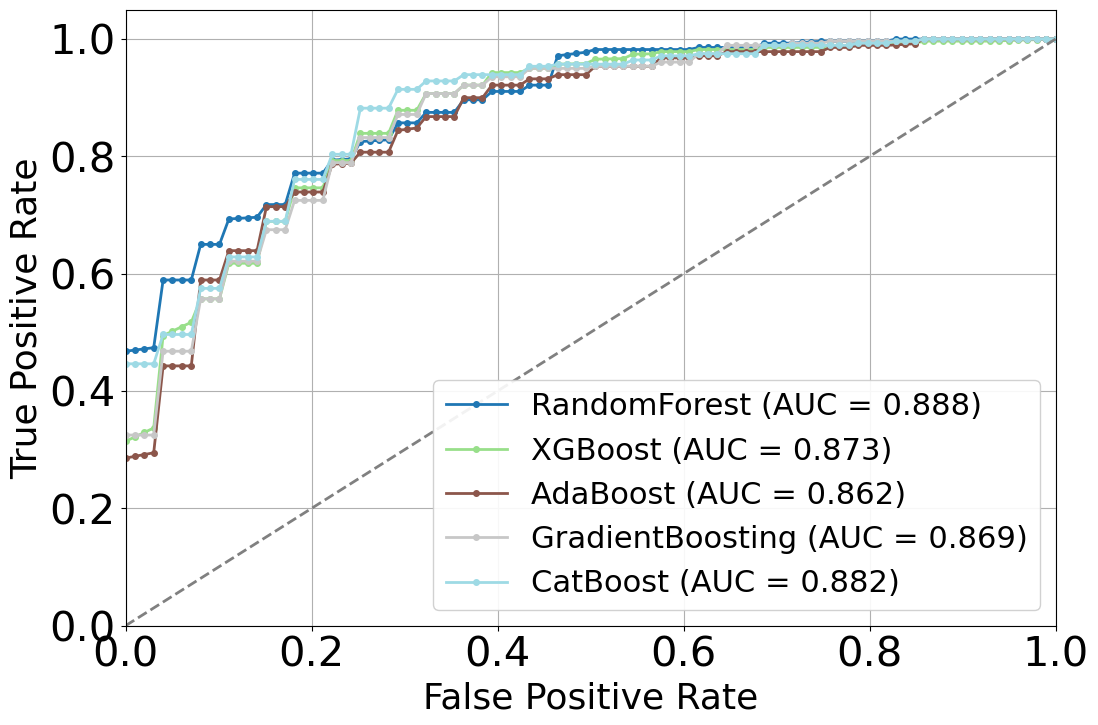

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [39]:
plot_combined_roc_curve(roc_curves_static, classifiers.keys())

Friedman Test Statistic: 7.234042553191502, p-value: 0.12402507392260259
Critical Difference: 1.9288274929443536


<Figure size 1400x800 with 0 Axes>

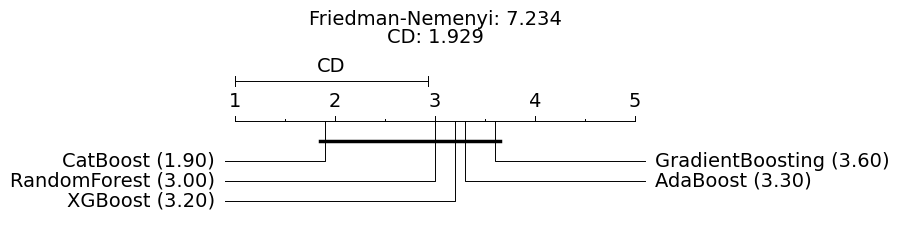

In [40]:
# FN Curve
df = pd.DataFrame(accuracy_scores_static)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.08, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### DES Training for Case/Control Classification

In [42]:
metric_sums_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

conf_matrices_des = {
    'KNORAE': [],
    'KNORAU': [],
    'KNOP': [],
    'DESMI': [],
    'METADES': [],
    'DESKNN': [],
    'DESP': [],
    'FIRE-KNORA-U': [],
    'FIRE-KNORA-E': [],
    'FIRE-METADES': [],
    'FIRE-DESKNN': [],
    'FIRE-DESP': [],
    'FIRE-KNOP': [],
}

roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)
feature_importance_runs = []

# Uncomment at least 2 classifiers for DES to work properly
base_classifiers = {
    #'DecisionTree': DecisionTreeClassifier(
    #    random_state=0, 
    #    criterion='gini', 
    #    max_depth=6, 
    #    min_samples_leaf=10, 
    #    min_samples_split=9
    #),
    #'LogisticRegression': LogisticRegression(
    #    random_state=0, 
    #    C=0.09659168435718246, 
    #    max_iter=100, 
    #    solver='lbfgs'
    #),
    #'NaiveBayes': GaussianNB(
    #    var_smoothing=0.0058873326349240295
    #),
    # 'KNeighbors': KNeighborsClassifier(
    #     metric='manhattan', 
    #     n_neighbors=15, 
    #     weights='uniform'
    # ),
    # 'MLP': MLPClassifier(
    #     random_state=0, 
    #     max_iter=1000, 
    #     alpha=0.0003079393718075164, 
    #     hidden_layer_sizes=195, 
    #     learning_rate_init=0.0001675266159417717
    # ),
    'SVC': SVC(probability=True, kernel = 'rbf', C = 1.5, gamma = 'auto'),
    'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
    'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
    'CB': CatBoostClassifier(depth = 3, iterations = 168, learning_rate = 0.1, verbose = 0),
    # 'LGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200) 
}

random_state = 0

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    
    # Get count of minority class
    min_count = y_test.value_counts().min()
    # Set up strategy to balance classes
    sampling_strategy_undersample = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test) 

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    xgb_fs = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs.fit(X_res, y_res)

    feature_importances = xgb_fs.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_50_features = [original_columns[i] for i in indices[:50]]
    current_run_features = {original_columns[i]: feature_importances[i] for i in indices[:50]}
    
    feature_importance_runs.append(current_run_features)

    X_res_fi = X_res[top_50_features]
    X_test_fi = X_test[top_50_features]
    
    model_pool = list(base_classifiers.values())
    
    for clf in model_pool:
        clf.fit(X_res_fi, y_res)
    
    des_models = {
        'KNORAE': KNORAE(pool_classifiers=model_pool, random_state=random_state),
        'KNORAU': KNORAU(pool_classifiers=model_pool, random_state=random_state),
        'DESMI': DESMI(pool_classifiers=model_pool, random_state=random_state),
        'METADES': METADES(pool_classifiers=model_pool, random_state=random_state),
        'DESKNN': DESKNN(pool_classifiers=model_pool, random_state=random_state),
        'DESP': DESP(pool_classifiers=model_pool, random_state=random_state),
        'KNOP': KNOP(pool_classifiers=model_pool, random_state=random_state, k=9),
        'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9, random_state=random_state),
        'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9, random_state=random_state),
        'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9, random_state=random_state),
        'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9, random_state=random_state),
        'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9, random_state=random_state),
        'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40, random_state=random_state)
    }

    for des_name, des_model in des_models.items():
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            des_model, X_res_fi, y_res, X_test_fi, y_test, clf_name=des_name
        )
        metric_sums_des[des_name]['accuracy'] += accuracy
        metric_sums_des[des_name]['precision'] += precision
        metric_sums_des[des_name]['recall'] += recall
        metric_sums_des[des_name]['f1'] += f1
        conf_matrices_des[des_name].append(conf_matrix)
        roc_curves[des_name].append((fpr, tpr))
        roc_aucs[des_name].append(roc_auc)
        accuracy_scores[des_name].append(accuracy)
        precision_scores[des_name].append(precision)
        recall_scores[des_name].append(recall)
        f1_scores[des_name].append(f1)

        print(f'Confusion Matrix for {des_name} at Random State {random_state}:\n{conf_matrix}\n')

Processing for Random State: 0
Number of test labels before resampling: 1    29
0    28
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    28
1    28
Name: BCaseControlStatus, dtype: int64
KNORAE - Accuracy: 0.8036, Precision: 0.8071, Recall: 0.8036, F1-Score: 0.8030
Confusion Matrix for KNORAE at Random State 0:
[[24  4]
 [ 7 21]]

KNORAE - Accuracy: 0.8036, Precision: 0.8071, Recall: 0.8036, F1-Score: 0.8030
Confusion Matrix for KNORAE at Random State 0:
[[24  4]
 [ 7 21]]

KNORAU - Accuracy: 0.8036, Precision: 0.8071, Recall: 0.8036, F1-Score: 0.8030
Confusion Matrix for KNORAU at Random State 0:
[[24  4]
 [ 7 21]]

KNORAU - Accuracy: 0.8036, Precision: 0.8071, Recall: 0.8036, F1-Score: 0.8030
Confusion Matrix for KNORAU at Random State 0:
[[24  4]
 [ 7 21]]

DESMI - Accuracy: 0.8214, Precision: 0.8231, Recall: 0.8214, F1-Score: 0.8212
Confusion Matrix for DESMI at Random State 0:
[[24  4]
 [ 6 22]]

DESMI - Accuracy: 0.8214, Precision: 0.8231, Recal

In [50]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))
    
    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4, 
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=13, frameon=True, framealpha=0.9)
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.show()

    display(FileLink(filename))


Average Metrics over 10 Random States:
KNORAE - Accuracy: 0.7893 ± 0.0413, Precision: 0.7943 ± 0.0420, Recall: 0.7893 ± 0.0413, F1-Score: 0.7884 ± 0.0416, AUC: 0.8897
KNORAU - Accuracy: 0.7893 ± 0.0413, Precision: 0.7943 ± 0.0420, Recall: 0.7893 ± 0.0413, F1-Score: 0.7884 ± 0.0416, AUC: 0.8610
KNOP - Accuracy: 0.7893 ± 0.0429, Precision: 0.7945 ± 0.0429, Recall: 0.7893 ± 0.0429, F1-Score: 0.7883 ± 0.0434, AUC: 0.8450
DESMI - Accuracy: 0.7857 ± 0.0375, Precision: 0.7929 ± 0.0379, Recall: 0.7857 ± 0.0375, F1-Score: 0.7844 ± 0.0378, AUC: 0.8884
METADES - Accuracy: 0.7893 ± 0.0429, Precision: 0.7945 ± 0.0429, Recall: 0.7893 ± 0.0429, F1-Score: 0.7883 ± 0.0434, AUC: 0.8897
DESKNN - Accuracy: 0.7804 ± 0.0392, Precision: 0.7881 ± 0.0403, Recall: 0.7804 ± 0.0392, F1-Score: 0.7789 ± 0.0395, AUC: 0.8843
DESP - Accuracy: 0.7768 ± 0.0409, Precision: 0.7819 ± 0.0410, Recall: 0.7768 ± 0.0409, F1-Score: 0.7757 ± 0.0415, AUC: 0.8862
FIRE-KNORA-U - Accuracy: 0.7911 ± 0.0392, Precision: 0.7961 ± 0.0396

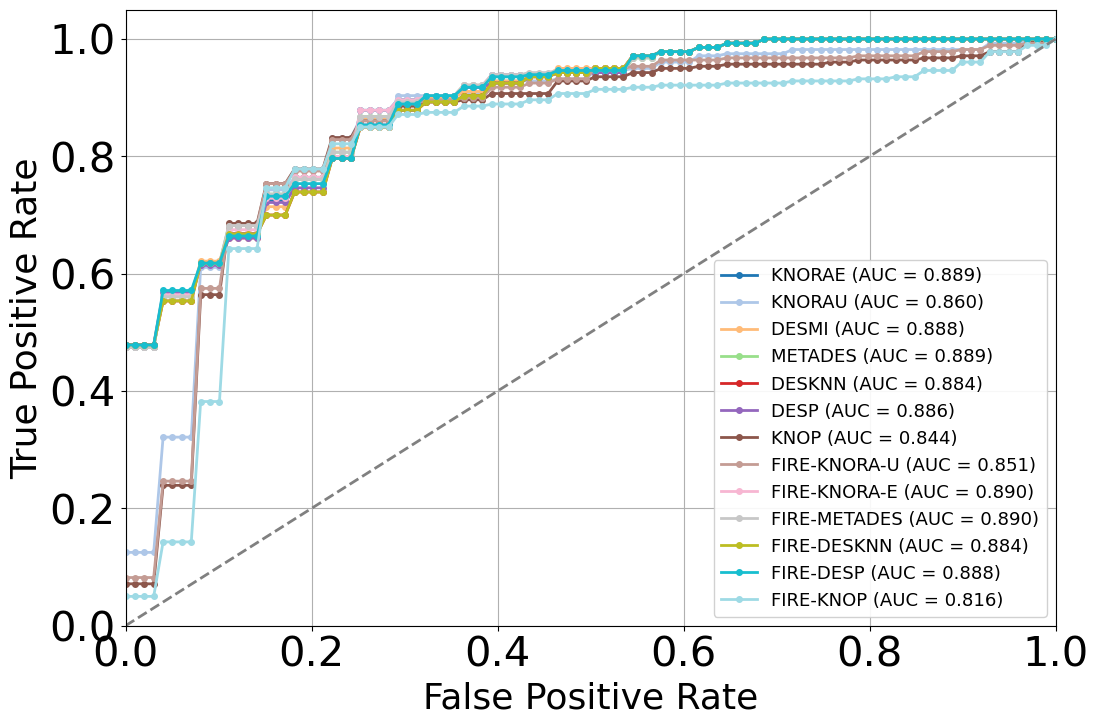

/home/researchsrv1/clement/DES4DepressionTest/code/bonk.svg

In [51]:
print('\nAverage Metrics over 10 Random States:')
for des_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[des_name])
    std_precision = np.std(precision_scores[des_name])
    std_recall = np.std(recall_scores[des_name])
    std_f1 = np.std(f1_scores[des_name])
    avg_auc = np.mean(roc_aucs[des_name])
    print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

plot_combined_roc_curve(roc_curves, list(des_models.keys()))

Friedman Test Statistic: 10.419947506561657, p-value: 0.5791700816970131
Critical Difference: 5.769621047847687


<Figure size 1400x1000 with 0 Axes>

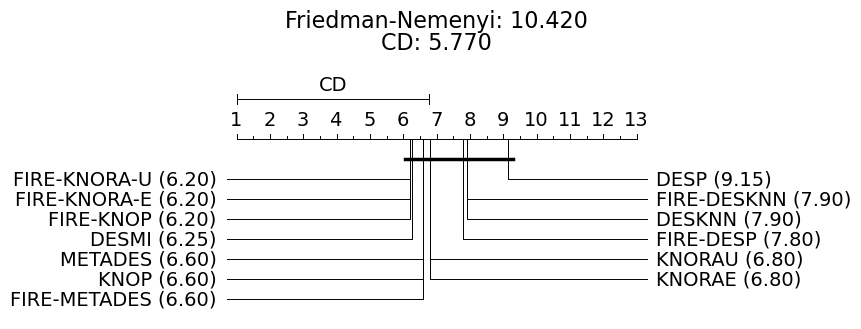

In [52]:
df = pd.DataFrame(accuracy_scores)
scores = [df[col].values for col in df.columns]

stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')

ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values

n_datasets = df.shape[0]
alpha = 0.05

cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')

classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]

plt.figure(figsize=(14, 10))

graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.xlabel('Classifiers')

plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()

Accuracy Comparison Table (DES vs Static Methods)
Rank Method               Accuracy   ±Std     AUC     
------------------------------------------------------------
1    Static_CatBoost      0.8089    ±0.0452 0.8827
2    DES_FIRE-KNORA-U     0.7911    ±0.0392 0.8519
3    DES_FIRE-KNOP        0.7911    ±0.0392 0.8166
4    DES_FIRE-KNORA-E     0.7911    ±0.0392 0.8903
5    DES_KNORAU           0.7893    ±0.0413 0.8610
6    DES_KNORAE           0.7893    ±0.0413 0.8897
7    DES_METADES          0.7893    ±0.0429 0.8897
8    DES_KNOP             0.7893    ±0.0429 0.8450
9    Static_RandomForest  0.7893    ±0.0491 0.8875
10   DES_FIRE-METADES     0.7893    ±0.0429 0.8902
11   DES_DESMI            0.7857    ±0.0375 0.8884
12   DES_FIRE-DESP        0.7821    ±0.0443 0.8884
13   DES_DESKNN           0.7804    ±0.0392 0.8843
14   DES_FIRE-DESKNN      0.7804    ±0.0392 0.8843
15   Static_AdaBoost      0.7804    ±0.0310 0.8631
16   DES_DESP             0.7768    ±0.0409 0.8862
17   Static_XGBoos

<Figure size 1400x600 with 0 Axes>

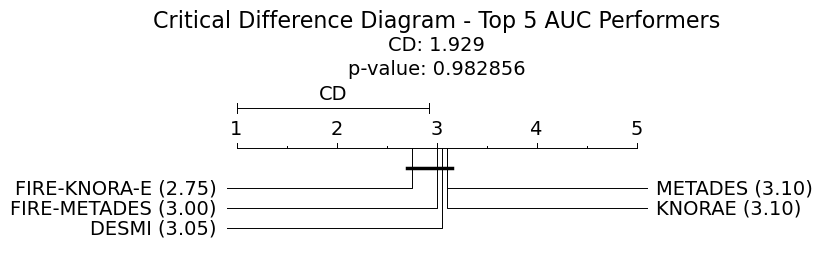

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt

# Create comparison tables between DES and Static methods

# Extract accuracy metrics for DES
des_accuracy_data = []
for method_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    std_accuracy = np.std(accuracy_scores[method_name])
    avg_auc = np.mean(roc_aucs[method_name])
    des_accuracy_data.append({
        'Method': f'DES_{method_name}',
        'Accuracy': avg_accuracy,
        'Accuracy_Std': std_accuracy,
        'AUC': avg_auc
    })

# Extract accuracy metrics for Static methods
static_accuracy_data = []
for method_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    std_accuracy = np.std(accuracy_scores_static[method_name])
    avg_auc = np.mean(roc_aucs_static[method_name])
    static_accuracy_data.append({
        'Method': f'Static_{method_name}',
        'Accuracy': avg_accuracy,
        'Accuracy_Std': std_accuracy,
        'AUC': avg_auc
    })

# Combine all data
all_accuracy_data = des_accuracy_data + static_accuracy_data

# Create accuracy comparison table (sorted by accuracy)
accuracy_df = pd.DataFrame(all_accuracy_data)
accuracy_df_sorted = accuracy_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
accuracy_df_sorted['Rank'] = range(1, len(accuracy_df_sorted) + 1)

print("Accuracy Comparison Table (DES vs Static Methods)")
print("=" * 60)
print(f"{'Rank':<4} {'Method':<20} {'Accuracy':<10} {'±Std':<8} {'AUC':<8}")
print("-" * 60)
for _, row in accuracy_df_sorted.iterrows():
    print(f"{row['Rank']:<4} {row['Method']:<20} {row['Accuracy']:.4f}    ±{row['Accuracy_Std']:.4f} {row['AUC']:.4f}")

print("\n")

# Create AUC comparison table (sorted by AUC)
auc_df_sorted = accuracy_df.sort_values('AUC', ascending=False).reset_index(drop=True)
auc_df_sorted['Rank'] = range(1, len(auc_df_sorted) + 1)

print("AUC Comparison Table (DES vs Static Methods)")
print("=" * 60)
print(f"{'Rank':<4} {'Method':<20} {'AUC':<8} {'Accuracy':<10} {'±Std':<8}")
print("-" * 60)
for _, row in auc_df_sorted.iterrows():
    print(f"{row['Rank']:<4} {row['Method']:<20} {row['AUC']:.4f}   {row['Accuracy']:.4f}    ±{row['Accuracy_Std']:.4f}")

# Statistical comparison of top 5 AUC performers
print("\n" + "="*80)
print("STATISTICAL COMPARISON OF TOP 5 AUC PERFORMERS")
print("="*80)

# Get top 5 methods by AUC
top_5_auc = auc_df_sorted.head(5)
print("Top 5 methods by AUC:")
for _, row in top_5_auc.iterrows():
    print(f"{row['Rank']}. {row['Method']}: {row['AUC']:.4f}")

# Extract AUC scores for top 5 methods
top_5_methods = top_5_auc['Method'].tolist()
top_5_auc_scores = []

for method in top_5_methods:
    if method.startswith('DES_'):
        method_key = method.replace('DES_', '')
        scores = roc_aucs[method_key]
    elif method.startswith('Static_'):
        method_key = method.replace('Static_', '')
        scores = roc_aucs_static[method_key]
    else:  # Classical methods
        method_key = method.replace('Classical_', '')
        scores = roc_aucs_classic[method_key]
    
    top_5_auc_scores.append(scores)

# Perform Friedman test on AUC scores
print(f"\nFriedman Test on AUC scores for top 5 methods:")
auc_stat, auc_p = friedmanchisquare(*top_5_auc_scores)
print(f'Friedman Test Statistic: {auc_stat:.4f}')
print(f'p-value: {auc_p:.6f}')

if auc_p < 0.05:
    print("Result: Significant differences detected between methods (p < 0.05)")
else:
    print("Result: No significant differences detected between methods (p >= 0.05)")

# Create dataframe for ranking analysis
top_5_auc_df = pd.DataFrame({method: scores for method, scores in zip(top_5_methods, top_5_auc_scores)})

# Calculate ranks and critical difference
auc_ranks = top_5_auc_df.rank(axis=1, method='average', ascending=False)
auc_average_ranks = auc_ranks.mean().values
n_datasets_top5 = top_5_auc_df.shape[0]

auc_cd = compute_CD(auc_average_ranks, n_datasets_top5, alpha='0.05')
print(f'Critical Difference: {auc_cd:.4f}')

# Create CD diagram
top_5_classifiers_ranked = [f"{method.split('_', 1)[1]} ({rank:.2f})" for method, rank in zip(top_5_methods, auc_average_ranks)]

plt.figure(figsize=(14, 6))
graph_ranks(auc_average_ranks, top_5_classifiers_ranked, cd=auc_cd, width=6, textspace=1)
plt.text(0.5, 1.20, f'CD: {auc_cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.05, "p-value: {:.6f}".format(auc_p), horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.title('Critical Difference Diagram - Top 5 AUC Performers', fontsize=16, pad=40)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

# Data from your tables
methods = [
    'Static_CatBoost', 'DES_FIRE-KNORA-U', 'DES_FIRE-KNOP', 'DES_FIRE-KNORA-E',
    'DES_KNORAU', 'DES_KNORAE', 'DES_METADES', 'DES_KNOP', 'Static_RandomForest',
    'DES_FIRE-METADES', 'DES_DESMI', 'DES_FIRE-DESP', 'DES_DESKNN', 
    'DES_FIRE-DESKNN', 'Static_AdaBoost', 'DES_DESP', 'Static_XGBoost', 
    'Static_GradientBoosting'
]

accuracy_scores = [
    0.8089, 0.7911, 0.7911, 0.7911, 0.7893, 0.7893, 0.7893, 0.7893, 0.7893,
    0.7893, 0.7857, 0.7821, 0.7804, 0.7804, 0.7804, 0.7768, 0.7750, 0.7750
]

auc_scores = [
    0.8827, 0.8519, 0.8166, 0.8903, 0.8610, 0.8897, 0.8897, 0.8450, 0.8875,
    0.8902, 0.8884, 0.8884, 0.8843, 0.8843, 0.8631, 0.8862, 0.8733, 0.8690
]

# Calculate Pearson correlation coefficient
correlation_coeff, p_value = pearsonr(accuracy_scores, auc_scores)

print("="*60)
print("PEARSON CORRELATION ANALYSIS")
print("="*60)
print(f"Pearson Correlation Coefficient (r): {correlation_coeff:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Statistical Significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

# Interpretation
if abs(correlation_coeff) < 0.3:
    strength = "weak"
elif abs(correlation_coeff) < 0.7:
    strength = "moderate"
else:
    strength = "strong"

direction = "positive" if correlation_coeff > 0 else "negative"
print(f"Correlation Strength: {strength.capitalize()} {direction} correlation")

# Create DataFrame for easier viewing
df = pd.DataFrame({
    'Method': methods,
    'Accuracy': accuracy_scores,
    'AUC': auc_scores
})

print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"Number of methods compared: {len(methods)}")
print(f"Accuracy range: {min(accuracy_scores):.4f} - {max(accuracy_scores):.4f}")
print(f"AUC range: {min(auc_scores):.4f} - {max(auc_scores):.4f}")

# Additional statistics
print(f"\nAccuracy - Mean: {np.mean(accuracy_scores):.4f}, Std: {np.std(accuracy_scores):.4f}")
print(f"AUC - Mean: {np.mean(auc_scores):.4f}, Std: {np.std(auc_scores):.4f}")

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(accuracy_scores, auc_scores, alpha=0.7, s=60)

# Add trend line
z = np.polyfit(accuracy_scores, auc_scores, 1)
p = np.poly1d(z)
plt.plot(accuracy_scores, p(accuracy_scores), "r--", alpha=0.8, linewidth=1)

plt.xlabel('Accuracy')
plt.ylabel('AUC')
plt.title(f'Accuracy vs AUC Correlation\n(r = {correlation_coeff:.4f}, p = {p_value:.4f})')
plt.grid(True, alpha=0.3)

# Add some method labels for interesting points
for i, method in enumerate(methods):
    if accuracy_scores[i] > 0.805 or auc_scores[i] > 0.89:  # Label high performers
        plt.annotate(method.replace('_', '\n'), 
                    (accuracy_scores[i], auc_scores[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TOP AND BOTTOM PERFORMERS")
print("="*60)

# Find methods with highest accuracy vs AUC discrepancies
df['Accuracy_rank'] = df['Accuracy'].rank(ascending=False)
df['AUC_rank'] = df['AUC'].rank(ascending=False)
df['Rank_difference'] = abs(df['Accuracy_rank'] - df['AUC_rank'])

print("Methods with largest ranking discrepancies between Accuracy and AUC:")
print(df.nlargest(5, 'Rank_difference')[['Method', 'Accuracy', 'AUC', 'Rank_difference']])

Pearson r: -0.082, p-value: 0.7478
